# Dynamic Matrix Control

**RESULT** here is not the same as my textbook.
**MAYBE** some bugs here

## Question

Consider following process with transfer function $G_p(s)$:

$$
g_p(s)=\frac
{0.5848(-0.3549s+1)}
{0.1828s^2+0.8627s+1}
$$

plot response using DMC with parameters:

|$\Delta t$|N|P|M|
|---|---|---|---|
|0.1|50|25|1|
|0.1|50|10|1|
|0.1|50| 8|1|
|0.1|50| 7|1|

In [1]:
import numpy as np;
import control;
import matplotlib.pyplot as plt;

## 1 Finite Step Response

In [2]:
num=0.5849*np.array([-0.3549,1.0])
den=[0.1828,0.8627,1.0]
Gp=control.tf(num,den)
print(Gp)


   -0.2076 s + 0.5849
-------------------------
0.1828 s^2 + 0.8627 s + 1



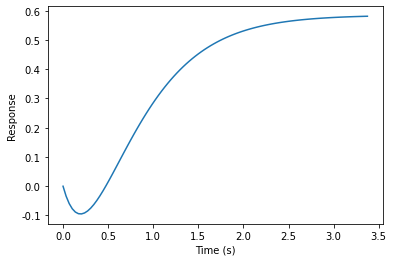

In [3]:
(T,yout)=control.step_response(Gp)
plt.plot(T,yout)
plt.xlabel("Time (s)")
plt.ylabel("Response")
plt.show()

## Simupy Response


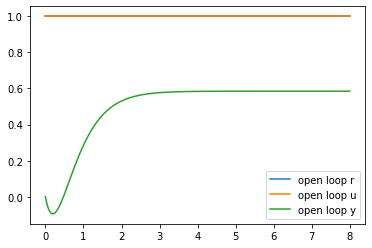

In [4]:
from simupy.block_diagram import BlockDiagram
import simupy.systems
Gp_ss=control.tf2ss(Gp)
process=simupy.systems.LTISystem(Gp_ss.A,Gp_ss.B,Gp_ss.C)
# construct reference
ref = simupy.systems.SystemFromCallable(lambda *args: np.ones(1), 0, 1)

plt.figure()

controller=simupy.systems.SystemFromCallable(
    lambda t,u:np.array(u[1]),
    2,1)

BD=BlockDiagram(controller,process,ref)
BD.connect(controller,process)
BD.connect(process,controller,outputs=[0],inputs=[0])
BD.connect(ref,controller,outputs=[0],inputs=[1])

result=BD.simulate(8)
plt.plot(result.t, result.y[:,2], label="open loop r")
plt.plot(result.t, result.y[:,0], label="open loop u")
plt.plot(result.t, result.y[:,1], label="open loop y")

plt.legend()
plt.show()

## Dynamic Matrix Control

use following cost function

$$
J={E^c}^T Q {E^c} + {\Delta u_f}^T R \Delta u_f
$$

solution is 

$$
\begin{align*}
\Delta u_f & = K * E \\
K &=(S_f^T Q S_f + R)^{-1} S_f^T Q\\
E &=Y_r-Y_0\\
\end{align*}
$$

- $S$ is Finite Step response  $[s_1,s_2,\dots, s_N]$,$S_{past}$ is  $[s_1,s_2,\dots, s_{N-1}]$,
- $S_f$ is 
- $\hat{d}$ is assumed as $y_k-\hat{y_k}$

In [5]:
def ModelPredictiveControl(delta_t,N,P,M):
    #get the FSR (Finite Step Response) to make Dynamic Matrix
    T=np.arange(N)*delta_t
    (T,S)=control.step_response(Gp,T)
    Sf=np.zeros((P,M))
    for i in range(P):
        for j in range(M):
            if i+j>=min(M,P):
                Sf[i,j]=S[i+j-min(M,P)+1]
    #coefficients of cost function
    Q=np.diagflat(np.ones((1,P)))
    R=np.zeros((M,M))#np.diagflat(np.ones((1,M)))
    #计算比例并取第一行
    a=(np.dot(np.dot(Sf.T,Q),Sf)+R)
    K=np.dot(np.linalg.inv(a),np.dot(Sf.T,Q))
    K1=K[0,:]

    # 构造误差加权向量
    h=0.5*np.ones(N)
    h[0]=1

    def MPC(t,input):
        global lastU,y0,lastT
        [y,r]=input
        yr=np.ones((P))*r #目标值
        if t==0:
            lastT=0 #上一次控制的时刻
            lastU=0 #上一次的控制信号
            y0=np.zeros((N)) #模型预测值
        elif t>=lastT and t<lastT+delta_t:
            lastT=lastT+delta_t
            d_hat=y-y0[0]
            y0=y0+h*d_hat  #预测值校正
            y0[0:-1]=y0[1:]  #移位设置该时刻初值
            e=yr-y0[0:P]
            du=np.dot(K1,e.T)  #计算控制增量
            lastU=lastU+du     #修正控制量
            y0=y0+S*du         #计算输出预测值
        
        return np.array(lastU)
    return MPC
(delta_t,N,P,M) = (0.1,50,25,1)
G=ModelPredictiveControl(delta_t,N,P,M)
G(0,np.array([0,0]))
G(0.1,np.array([1,1]))

array(0)

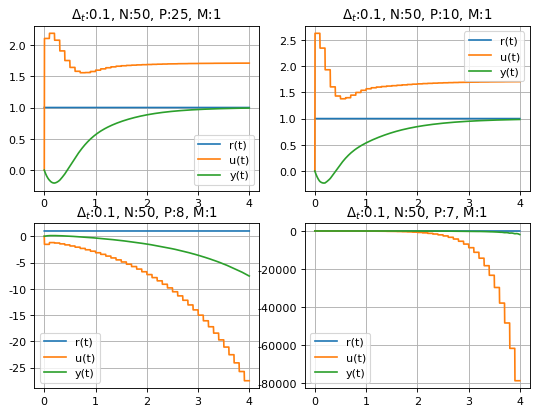

In [6]:
list=[
    (0.1,50,25,1),
    (0.1,50,10,1),
    (0.1,50,8,1),
    (0.1,50,7,1),
]
plt.figure(figsize=(8, 6), dpi=80)
for i,(delta_t,N,P,M) in enumerate(list):
    title="$\Delta_t$:%.1f, N:%d, P:%d, M:%d"%(delta_t,N,P,M)
    
    controller=simupy.systems.SystemFromCallable(
        ModelPredictiveControl(delta_t,N,P,M),
        2,1)

    BD=BlockDiagram(controller,process,ref)
    BD.connect(controller,process)
    BD.connect(process,controller,outputs=[0],inputs=[0])
    BD.connect(ref,controller,outputs=[0],inputs=[1])

    result=BD.simulate(np.arange(0,4,0.002))
    plt.subplot(2,2,i+1)
    plt.plot(result.t, result.y[:,2], label="r(t)")
    plt.plot(result.t, result.y[:,0], label="u(t)")
    plt.plot(result.t, result.y[:,1],label="y(t)")
    plt.title(title)
    plt.grid(True)
    plt.legend()
plt.show()

## References

- Siang Lim.February 2020.[Implementing Dynamic Matrix Control in Python](https://github.com/csianglim/DMC/blob/master/DMC.ipynb)
- Matlab.[Dynamic Matrix Control Tutorial](https://www.mathworks.com/matlabcentral/mlc-downloads/downloads/submissions/19479/versions/1/previews/html/dmctutorial.html)